# Multi Author Writing Style Analysis

The following notebook presents three different approaches to the problem of distingushing when in a sequence of paragraphs,
the author changes. The first approach disregrads the order of the paragraphs, opting instead to view samples as pairs of paragraphs.
It processes the paragraphs with a siamese network, which is a neural network that takes two inputs and outputs a single value.
The second approach adds a recurrent layer to the siamese network, allowing it to take into account a sequence of paragraphs.
The third approach builds on the second by augmenting the input with a manually engineered feature vector.

In [1]:
import numpy as np
import random
import pickle
import torch
import warnings
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd

In [46]:
warnings.filterwarnings('ignore')


## data

In [2]:
# model = SentenceTransformer('all-MiniLM-L6-v2')
# data = { str(i): get_data(i, model.encode) for i in range(1, 4) }
# pickle.dump(data, open('data/data.pkl', 'wb'))
data = pickle.load(open('data/data.pkl', 'rb'))

### pair data

In [3]:
def paired_samples(data_split):
    """turns data set into pair of consectuve sentences (flattens multi paragraph samples into pairs)"""
    pairs = []
    for problem_id in data_split.keys():
        texts = data_split[problem_id]['text']
        targets = data_split[problem_id]['truth']['changes']
        if len(texts) - 1 != len(targets):
            # TODO: fix. a few of the samples have more than one paragraph, making .readlines() wrong
            # print(f'problem {problem_id} has {len(texts)} texts and {len(targets)} targets')
            continue
        for target, text1, text2 in zip(targets, texts[:-1], texts[1:]):
            pairs.append((text1, text2, target))
    random.shuffle(pairs)
    return pairs

In [4]:
def get_pair_batches(data_split, device, batch_size=32):
    pairs = paired_samples(data_split)
    while True:
        # perm = np.random.permutation(len(pairs))
        x1 = torch.tensor(np.array([p[0] for p in pairs])).to(device)
        x2 = torch.tensor(np.array([p[1] for p in pairs])).to(device)
        y = torch.tensor(np.array([p[2] for p in pairs])).to(device)
        perm = torch.randperm(len(pairs))
        for i in range(0, len(pairs), batch_size):
            batch = perm[i:i+batch_size]
            yield (x1[batch], x2[batch]), y[batch]

### sequence data

In [5]:
def get_sequence_batches(data_split, device, batch_size=32):
    """turns data set into sequence of sentences (flattens multi paragraph samples into sequence)"""
    x, y = [], []
    for problem_id in data_split.keys():
        texts = data_split[problem_id]['text']
        targets = data_split[problem_id]['truth']['changes']
        if len(texts) - 1 != len(targets):
            continue
        x.append(torch.tensor(texts).to(device))
        y.append(torch.tensor(targets).to(device))
    while True:
        perm = torch.randperm(len(x))
        for i in range(0, len(x), batch_size):
            batch = perm[i:i+batch_size]
            x_batch = [x[i] for i in batch]
            y_batch = [torch.eye(2)[y[i]] for i in batch]
            # pad with zero vectors
            x_batch = pad_sequence(x_batch, batch_first=True, padding_value=0)
            y_batch = pad_sequence(y_batch, batch_first=True, padding_value=0)
            yield x_batch, y_batch

## models

In [6]:
class SiameseNet(torch.nn.Module):
    def __init__(self, config, embed_dim=384):
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = config['hidden_dim']
        self.dropout = config['dropout']
        self.linear1 = torch.nn.Linear(self.embed_dim, self.hidden_dim)
        self.linear2 = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.linear3 = torch.nn.Linear(self.hidden_dim, 1)
        self.dropout = torch.nn.Dropout(self.dropout)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x, y=None):
        x1, x2 = x
        x1_hat = self.dropout(x1)
        x1_hat = self.linear1(x1_hat)
        x1_hat = F.gelu(x1_hat)
        x2_hat = self.dropout(x2)
        x2_hat = self.linear1(x2_hat)
        x2_hat = F.gelu(x2_hat)
        y_hat = torch.abs(x1_hat - x2_hat)
        y_hat = self.linear2(y_hat)
        y_hat = F.gelu(y_hat)
        y_hat = self.dropout(y_hat)
        y_hat = self.linear3(y_hat)
        y_hat = self.sigmoid(y_hat)
        if y is not None:
            loss = torch.nn.functional.binary_cross_entropy(y_hat, y.float().unsqueeze(1))
            return y_hat, loss
        return y_hat

In [7]:
class RecurrentSiameseNet(torch.nn.Module):
    def __init__(self, embed_dim=384):
        super().__init__()
        self.embed_dim = embed_dim
        self.lstm = torch.nn.LSTM(self.embed_dim, 128, batch_first=True)
        self.linear1 = torch.nn.Linear(128 * 2, 128 * 2)
        self.linear2 = torch.nn.Linear(128 * 2, 128 * 2)
        self.linear3 = torch.nn.Linear(128 * 2, 1)
        self.dropout = torch.nn.Dropout(0.2)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x, y=None):
        x1, x2 = x
        y_hat = torch.abs(x1 - x2)
        y_hat, _ = self.lstm(y_hat)
        y_hat = self.dropout(y_hat)
        y_hat = self.linear1(y_hat)
        y_hat = F.gelu(y_hat)
        y_hat = self.linear2(y_hat)
        y_hat = F.gelu(y_hat)
        y_hat = self.dropout(y_hat)
        y_hat = self.linear3(y_hat)
        y_hat = self.sigmoid(y_hat)
        if y is not None:
            loss = torch.nn.functional.binary_cross_entropy(y_hat, y.float().unsqueeze(1))
            return y_hat, loss
        return y_hat

In [8]:
class AugmentedRecurrentSiameseNet(torch.nn.Module):
    def __init__(self, embed_dim=384):
        super().__init__()
        self.embed_dim = embed_dim
        self.lstm = torch.nn.LSTM(self.embed_dim, 128, batch_first=True)
        self.linear1 = torch.nn.Linear(128 * 2, 128 * 2)
        self.linear2 = torch.nn.Linear(128 * 2, 128 * 2)
        self.linear3 = torch.nn.Linear(128 * 2, 1)
        self.dropout = torch.nn.Dropout(0.3)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x, y=None):
        x1, x2 = x
        y_hat = torch.abs(x1 - x2)
        y_hat, _ = self.lstm(y_hat)
        y_hat = self.dropout(y_hat)
        y_hat = self.linear1(y_hat)
        y_hat = F.gelu(y_hat)
        y_hat = self.linear2(y_hat)
        y_hat = F.gelu(y_hat)
        y_hat = self.dropout(y_hat)
        y_hat = self.linear3(y_hat)
        y_hat = self.sigmoid(y_hat)
        if y is not None:
            loss = torch.nn.functional.binary_cross_entropy(y_hat, y.float().unsqueeze(1))
            return y_hat, loss
        return y_hat

## train

In [32]:
def evaluate(metrics, model, train_batches, valid_batches, steps=20):
    for batch_name, batches in [('train', train_batches), ('valid', valid_batches)]:
        loss, f1 = evaluate_split(model, batches, steps=steps)
        metrics[batch_name + '_loss'].append(loss)
        metrics[batch_name + '_f1'].append(f1)
        model.eval()
    model.train()
    return metrics

def evaluate_split(model, batches, steps):
    f1_scores, losses = [], []
    for i in range(steps):
        x, y = next(batches)
        y_hat, loss = model(x, y)
        losses.append(loss.item())
        y_hat = (y_hat > 0.5).cpu().numpy().astype(int)
        y = y.cpu().numpy().astype(int)
        f1_scores.append(f1_score(y, y_hat))
    return np.mean(losses), np.mean(f1_scores)

def train(model, optimizer, train_batches, valid_batches, n_steps):
    metrics = {'train_loss': [], 'train_f1': [], 'valid_loss': [], 'valid_f1': []}
    for i in range(n_steps):
        x, y = next(train_batches)
        y_hat, loss = model(x, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % (n_steps // 100) == 0:
            metrics = evaluate(metrics, model, train_batches, valid_batches)
    final = evaluate(metrics, model, train_batches, valid_batches, steps=100)
    return metrics, {k: v[-1] for k, v in final.items()}

### experiments

In [49]:
def hyper_params():
    """return random hyperparameters"""
    return {
        'lr': 10 ** random.uniform(-5, -2),
        'dropout': random.uniform(0, 0.5),
        'hidden_dim': random.randint(64, 256),
        'batch_size': [16, 32, 64, 128][random.randint(0, 2)],
        'n_steps': [1000, 2000, 4000][random.randint(0, 2)]
    }

def hyper_param_search(model_fn, batch_fn, dataset, n_trials=10):
    """search hyperparameters for a given model and dataset"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hyper_param_metrics = []
    for i in tqdm(range(n_trials)):
        config = hyper_params()
        model = model_fn(config).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        train_batches = batch_fn(dataset['train'], device, config['batch_size'])
        valid_batches = batch_fn(dataset['validation'], device, config['batch_size'])
        _, final= train(model, optimizer, train_batches, valid_batches, config['n_steps'])
        hyper_param_metrics.append({**config, **final})
    df = pd.DataFrame(hyper_param_metrics).sort_values('valid_f1', ascending=False)
    return df

df = hyper_param_search(SiameseNet, get_pair_batches, data['2'], n_trials=100)

100%|██████████| 100/100 [16:04<00:00,  9.64s/it]


### analysis

In [50]:
df

,lr,dropout,hidden_dim,batch_size,n_steps,train_loss,train_f1,valid_loss,valid_f1
54,0.003354,0.045201,198,32,1000,0.510152,0.730739,0.622040,0.608924
89,0.004585,0.242904,176,64,1000,0.524103,0.712964,0.588820,0.606130
93,0.000031,0.064450,74,16,1000,0.694400,0.635961,0.695492,0.604892
50,0.002699,0.214234,125,64,2000,0.464850,0.767772,0.632953,0.598406
20,0.005817,0.051023,159,64,2000,0.303641,0.868720,0.906419,0.597680
...,...,...,...,...,...,...,...,...,...
81,0.000012,0.244412,83,16,4000,0.688859,0.000000,0.687563,0.000000
40,0.000018,0.075952,166,32,1000,0.690970,0.000000,0.688489,0.000000
75,0.000013,0.077382,191,64,1000,0.690614,0.000000,0.689140,0.000000
1,0.000021,0.066625,218,16,1000,0.690743,0.000000,0.689764,0.000000


In [ ]:
def plot_metrics(metrics):
    # black theme matplotlib
    # set font to serif
    plt.rcParams['font.family'] = 'serif'
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    f1_valid = metrics['valid']['f1']
    f1_train = metrics['train']['f1']
    loss_valid = metrics['valid']['loss']
    loss_train = metrics['train']['loss']
    axes[0].plot(f1_valid, label='valid')
    axes[0].plot(f1_train, label='train')
    axes[0].set_title('f1')
    axes[0].legend()
    axes[1].plot(loss_valid, label='valid')
    axes[1].plot(loss_train, label='train')
    axes[1].set_title('loss')
    axes[1].legend()
    plt.show()

100%|██████████| 6000/6000 [00:13<00:00, 434.09it/s]


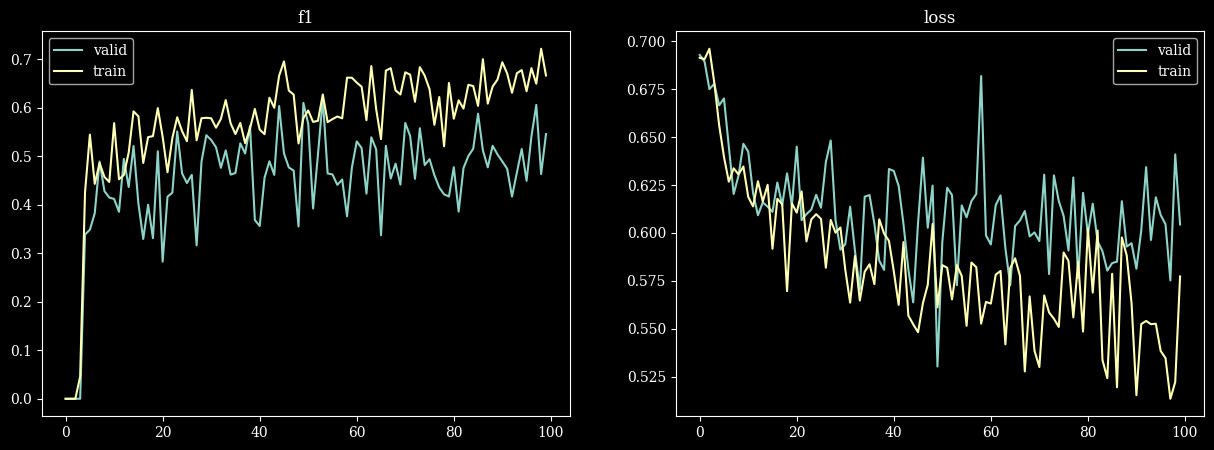

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNet(hidden_dim=42, dropout=0.3).to(device)
batch_size = 16
train_batches = get_pair_batches(paired_samples(data['2']['train']), batch_size, device)
valid_batches = get_pair_batches(paired_samples(data['2']['validation']), batch_size, device)
metrics = train(model, train_batches, valid_batches, 6000)
plot_metrics(metrics)